In [213]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import holidays

In [214]:
# Load your time series data
df = pd.read_csv('LSTM Dataset.csv')
df.tail(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc
14595,Sunday,12/31/2023,19:00,31.12.2023 19.00.00,1681.0,1,0,0.0,No Rain
14596,Sunday,12/31/2023,20:00,31.12.2023 20.00.00,297.0,1,0,0.0,No Rain
14597,Sunday,12/31/2023,21:00,31.12.2023 21.00.00,0.0,1,0,0.0,No Rain
14598,Sunday,12/31/2023,22:00,31.12.2023 22.00.00,0.0,1,0,0.0,No Rain
14599,Sunday,12/31/2023,23:00,31.12.2023 23.00.00,0.0,1,0,0.0,No Rain


In [215]:
ph_holidays = holidays.PH()
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x in ph_holidays else 0)
df.head(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc,is_holiday
0,Saturday,1/1/2022,4:00,01.01.2022 04.00.00,0.0,1,0,0.0,No Rain,1
1,Saturday,1/1/2022,5:00,01.01.2022 05.00.00,0.0,1,0,0.0,No Rain,1
2,Saturday,1/1/2022,6:00,01.01.2022 06.00.00,525.0,1,0,0.0,No Rain,1
3,Saturday,1/1/2022,7:00,01.01.2022 07.00.00,610.0,1,0,0.0,No Rain,1
4,Saturday,1/1/2022,8:00,01.01.2022 08.00.00,684.0,1,0,0.0,No Rain,1


In [216]:
df.drop(['Date', 'Time', 'rain_amount', 'rain_desc'], axis=1, inplace=True)
df.head(31)

,Day,DateAndTime,Entry,is_weekend,rain_class,is_holiday
0,Saturday,01.01.2022 04.00.00,0.0,1,0,1
1,Saturday,01.01.2022 05.00.00,0.0,1,0,1
2,Saturday,01.01.2022 06.00.00,525.0,1,0,1
3,Saturday,01.01.2022 07.00.00,610.0,1,0,1
4,Saturday,01.01.2022 08.00.00,684.0,1,0,1
5,Saturday,01.01.2022 09.00.00,770.0,1,0,1
6,Saturday,01.01.2022 10.00.00,1022.0,1,0,1
7,Saturday,01.01.2022 11.00.00,1248.0,1,0,1
8,Saturday,01.01.2022 12.00.00,1048.0,1,0,1
9,Saturday,01.01.2022 13.00.00,1199.0,1,0,1


In [217]:
df['Date Time'] = pd.to_datetime(df['DateAndTime'], format='%d.%m.%Y %H.%M.%S')
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year
df.drop(['DateAndTime', 'Day', 'is_weekend'], axis=1, inplace=True)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

model_features = ['hour', 'day_of_week', 'is_weekend','is_holiday', 'month', 'year', 'rain_class']
df_model = df[model_features]

df.head(30)

,Entry,rain_class,is_holiday,Date Time,hour,day_of_week,month,year,is_weekend
0,0.0,0,1,2022-01-01 04:00:00,4,5,1,2022,1
1,0.0,0,1,2022-01-01 05:00:00,5,5,1,2022,1
2,525.0,0,1,2022-01-01 06:00:00,6,5,1,2022,1
3,610.0,0,1,2022-01-01 07:00:00,7,5,1,2022,1
4,684.0,0,1,2022-01-01 08:00:00,8,5,1,2022,1
5,770.0,0,1,2022-01-01 09:00:00,9,5,1,2022,1
6,1022.0,0,1,2022-01-01 10:00:00,10,5,1,2022,1
7,1248.0,0,1,2022-01-01 11:00:00,11,5,1,2022,1
8,1048.0,0,1,2022-01-01 12:00:00,12,5,1,2022,1
9,1199.0,0,1,2022-01-01 13:00:00,13,5,1,2022,1


In [218]:
# Display the DataFrame before normalization
print(df_model.dtypes)
df_model.head(30)


hour           int32
day_of_week    int32
is_weekend     int64
is_holiday     int64
month          int32
year           int32
rain_class     int64
dtype: object


,hour,day_of_week,is_weekend,is_holiday,month,year,rain_class
0,4,5,1,1,1,2022,0
1,5,5,1,1,1,2022,0
2,6,5,1,1,1,2022,0
3,7,5,1,1,1,2022,0
4,8,5,1,1,1,2022,0
5,9,5,1,1,1,2022,0
6,10,5,1,1,1,2022,0
7,11,5,1,1,1,2022,0
8,12,5,1,1,1,2022,0
9,13,5,1,1,1,2022,0


In [219]:
from sklearn.preprocessing import MinMaxScaler
import joblib

df_model = df[model_features + ['Entry']]

# Normalize all features except 'Entry'
scaler = MinMaxScaler(feature_range=(0, 1))
df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])

# Save the scaler for the features
joblib.dump(scaler, 'model/scaler_features.pkl')

# Ensure 'Entry' column exists in df_model
if 'Entry' in df_model.columns:
    # Normalize the 'Entry' column separately
    scaler_entry = MinMaxScaler(feature_range=(0, 1))
    df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])
    
    # Save the scaler for the 'Entry' column
    joblib.dump(scaler_entry, 'model/scaler_entry.pkl')
else:
    print("Error: 'Entry' column not found in df_model")


C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_12084\1949296345.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_12084\1949296345.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
# Display the DataFrame after normalization
print("After normalization:")
df_model.head(20)

After normalization:


,hour,day_of_week,is_weekend,is_holiday,month,year,rain_class,Entry
0,0.000000,0.833333,1.0,1.0,0.0,0.0,0.0,0.000000
1,0.052632,0.833333,1.0,1.0,0.0,0.0,0.0,0.000000
2,0.105263,0.833333,1.0,1.0,0.0,0.0,0.0,0.082121
3,0.157895,0.833333,1.0,1.0,0.0,0.0,0.0,0.095417
4,0.210526,0.833333,1.0,1.0,0.0,0.0,0.0,0.106992
5,0.263158,0.833333,1.0,1.0,0.0,0.0,0.0,0.120444
6,0.315789,0.833333,1.0,1.0,0.0,0.0,0.0,0.159862
7,0.368421,0.833333,1.0,1.0,0.0,0.0,0.0,0.195214
8,0.421053,0.833333,1.0,1.0,0.0,0.0,0.0,0.163929
9,0.473684,0.833333,1.0,1.0,0.0,0.0,0.0,0.187549


In [221]:
print("After normalization:")
print(df_model.dtypes)

After normalization:
hour           float64
day_of_week    float64
is_weekend     float64
is_holiday     float64
month          float64
year           float64
rain_class     float64
Entry          float64
dtype: object


<Axes: >

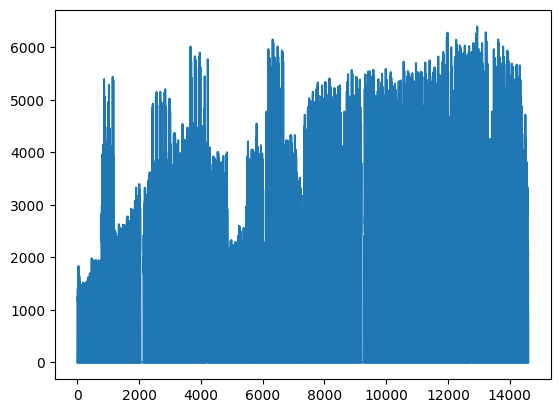

In [222]:
entry = df['Entry']
entry.plot()

In [223]:
def df_to_X_y(df, window_size=20):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][7]  # 'Entry' is the 7th column (index 6)
        y.append(label)
    return np.array(X), np.array(y)

In [224]:
X, y = df_to_X_y(df_model)
X.shape, y.shape

((14580, 20, 8), (14580,))

In [225]:
# Determine the split points
train_split_point = int(len(X) * 0.8)
valntest_split_point = int(len(X) * 0.9)

# Split the data
X_train, X_val, X_test = X[:train_split_point], X[train_split_point:valntest_split_point], X[valntest_split_point:]
y_train, y_val, y_test = y[:train_split_point], y[train_split_point:valntest_split_point], y[valntest_split_point:]

# Print the shapes to verify the splits
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11664, 20, 8), (11664,), (1458, 20, 8), (1458,), (1458, 20, 8), (1458,))

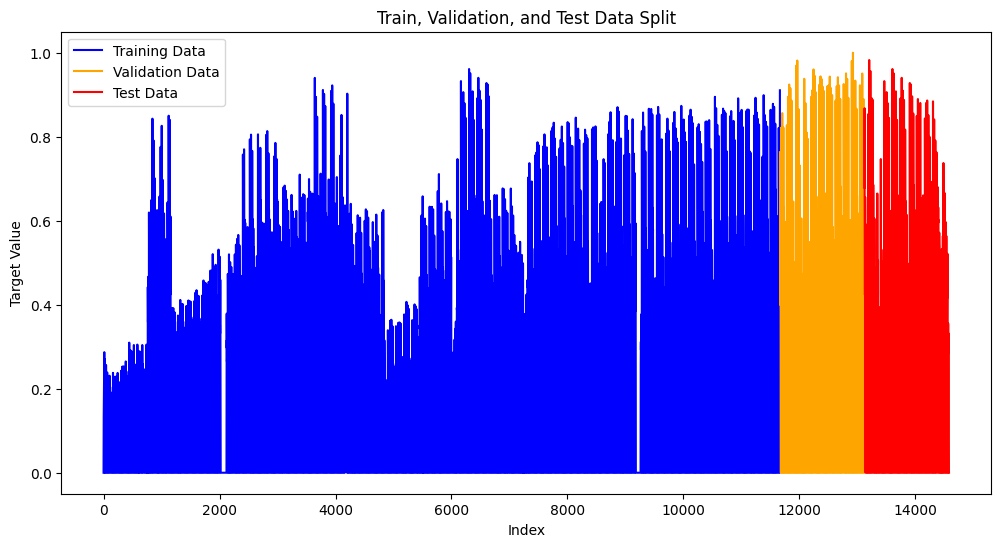

In [226]:
import matplotlib.pyplot as plt
# Visualization

date_time = df['Date Time']
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(range(train_split_point), y_train, label='Training Data', color='blue')

# Plot the validation data
plt.plot(range(train_split_point, valntest_split_point), y_val, label='Validation Data', color='orange')

# Plot the test data
plt.plot(range(valntest_split_point, len(X)), y_test, label='Test Data', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Train, Validation, and Test Data Split')
plt.legend()

# Show the plot
plt.show()

In [227]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [228]:
model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

In [229]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])


Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0325 - val_loss: 0.0154
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 10/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 12/100
365/365 ━━━━

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go

# Extract the 'Date Time' column for the test set
date_time_test = df['Date Time'][-len(y_test):]  # Use the date time series for the test set

# Load the scaler for inverse transformation
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Check the length of y_pred to ensure it matches y_test
#print(f"Length of y_pred: {len(y_pred)}")
#print(f"Length of y_test: {len(y_test)}")

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y_test, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
# Calculate adjusted R-squared
n = len(y_test)
p = X_test.shape[2]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=date_time_test, y=y_true_inv.flatten(), mode='lines', name='Actual Test Values'))
fig.add_trace(go.Scatter(x=date_time_test, y=y_pred_inv.flatten(), mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Test Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Root Mean Squared Error (RMSE): 295.2801499271752
Mean Absolute Error (MAE): 182.27914951989027
R-squared (R²): 0.952448371534809
Adjusted R-squared: 0.9521858366640557


In [231]:
print(f"Length of the dataset: {len(X)}")

# Make predictions on the entire dataset
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
# Calculate adjusted R-squared
n = len(y_test)
p = X_test.shape[2]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Create a DataFrame with all features and the true and forecasted values
df_features_with_predictions = df.iloc[-len(y_true_inv):].copy()

# Rename the 'Entry' column to 'Actual Values'
df_features_with_predictions.rename(columns={'Entry': 'Actual Values'}, inplace=True)

# Add the 'Forecasted Values' column
df_features_with_predictions['Forecasted Values'] = y_pred_inv.flatten()

# Reorder the columns
df_features_with_predictions = df_features_with_predictions[['Date Time', 'hour', 'day_of_week', 'is_weekend', 'is_holiday', 'month', 'year', 'rain_class', 'Actual Values', 'Forecasted Values']]

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Actual Values'], mode='lines', name='Actual Values'))
fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Forecasted Values'], mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

Length of the dataset: 14580
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Root Mean Squared Error (RMSE): 214.21923327278074
Mean Absolute Error (MAE): 134.0019890260631
R-squared (R²): 0.9730181573704894
Adjusted R-squared: 0.9728691892952401


In [232]:
import plotly.express as px

# Group the data by hour and calculate the mean for Actual Values and Forecasted Values
hourly_trends = df_features_with_predictions.groupby('hour')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Display the hourly trends DataFrame
print(hourly_trends)

# Plot the hourly trends using Plotly
fig = px.line(hourly_trends, x='hour', y=['Actual Values', 'Forecasted Values'], title='Hourly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Entry',
    legend_title='Legend'
)

# Show the plot
fig.show()

    hour  Actual Values  Forecasted Values
0      4      13.554184           6.319616
1      5    1992.597165        1991.013672
2      6    3063.263603        3029.303223
3      7    3670.468907        3658.181152
4      8    3230.871056        3265.149414
5      9    2801.925926        2738.676270
6     10    2414.137860        2502.946533
7     11    2397.104024        2377.024658
8     12    2385.529721        2345.593994
9     13    2299.090992        2325.753174
10    14    2290.140832        2318.940918
11    15    2425.228624        2448.760010
12    16    2794.812757        2779.636475
13    17    3113.893004        3137.853271
14    18    2990.024234        3138.179688
15    19    2714.909465        2742.645996
16    20    2218.021491        2261.214111
17    21    1572.274577        1553.526733
18    22      84.217421          83.839508
19    23       9.782122          24.248285


In [233]:
# Group the data by day of the week and calculate the mean for Actual Values and Forecasted Values
daily_trends = df_features_with_predictions.groupby('day_of_week')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Sort the daily trends DataFrame to start with Sunday
daily_trends['day_of_week'] = daily_trends['day_of_week'].map({6: 'Sunday', 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday'})
daily_trends = daily_trends.set_index('day_of_week').reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

# Plot the daily trends using Plotly
fig = px.line(daily_trends, x='day_of_week', y=['Actual Values', 'Forecasted Values'], title='Daily Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
        ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )
)

# Show the plot
fig.show()

In [234]:
import pandas as pd
import plotly.express as px

# Group the data by month and calculate the mean for Actual Values and Forecasted Values
yearly_trends = df_features_with_predictions.groupby('month')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Map the month numbers to month names
yearly_trends['month'] = yearly_trends['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Sort the DataFrame by month order
yearly_trends['month'] = pd.Categorical(yearly_trends['month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], ordered=True)
yearly_trends = yearly_trends.sort_values('month')

# Plot the yearly trends using Plotly
fig = px.line(yearly_trends, x='month', y=['Actual Values', 'Forecasted Values'], title='Yearly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ],
        ticktext=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ]
    )
)

# Show the plot
fig.show()

In [235]:
# DO NOT RUN THIS!
'''from sklearn.model_selection import TimeSeriesSplit
# Cross-Validation
def time_series_cv(df_model, n_splits=5, window_size=19):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_rmse = []
    all_mae = []
    all_r2 = []
    
    for train_index, val_index in tscv.split(df_model):
        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]
        
        # Prepare data
        X_train, y_train = df_to_X_y(df_train, window_size)
        X_val, y_val = df_to_X_y(df_val, window_size)
        
        # Build the model
        model = Sequential()
        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='linear'))
        model.add(Dense(1, activation='linear'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the model
        model.fit(X_train, y_train, epochs=100, verbose=0)

        # Make predictions
        y_pred = model.predict(X_val)

        # Inverse transform the predictions and actual values
        df_pred = pd.DataFrame(y_pred, columns=['Entry'])
        df_actual = pd.DataFrame(y_val, columns=['Entry'])
        y_pred_inv = scaler_entry.inverse_transform(df_pred)
        y_true_inv = scaler_entry.inverse_transform(df_actual)

        # Round the predictions to the nearest whole number
        y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
        y_true_inv = np.round(np.maximum(y_true_inv, 0))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        r2 = r2_score(y_true_inv, y_pred_inv)

        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)

    return all_rmse, all_mae, all_r2

# Perform Time Series Cross-Validation
rmse_list, mae_list, r2_list = time_series_cv(df_model)

# Print the results
print("RMSE for each fold:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))
print("MAE for each fold:", mae_list)
print("Mean MAE:", np.mean(mae_list))
print("R-squared for each fold:", r2_list)
print("Mean R²:", np.mean(r2_list))'''

'from sklearn.model_selection import TimeSeriesSplit\n# Cross-Validation\ndef time_series_cv(df_model, n_splits=5, window_size=19):\n    tscv = TimeSeriesSplit(n_splits=n_splits)\n    \n    all_rmse = []\n    all_mae = []\n    all_r2 = []\n    \n    for train_index, val_index in tscv.split(df_model):\n        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]\n        \n        # Prepare data\n        X_train, y_train = df_to_X_y(df_train, window_size)\n        X_val, y_val = df_to_X_y(df_val, window_size)\n        \n        # Build the model\n        model = Sequential()\n        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))\n        model.add(LSTM(64, return_sequences=True))\n        model.add(Dropout(0.2))\n        model.add(LSTM(64))\n        model.add(Dropout(0.2))\n        model.add(Dense(32, activation=\'linear\'))\n        model.add(Dense(1, activation=\'linear\'))\n\n        # Compile the model\n        model.compile(optimizer=\'adam\', loss=

In [236]:
# Calculate mean and standard deviation for holidays and non-holidays
mean_holiday = df[df['is_holiday'] == 1]['Entry'].mean()
std_holiday = df[df['is_holiday'] == 1]['Entry'].std()
mean_non_holiday = df[df['is_holiday'] == 0]['Entry'].mean()
std_non_holiday = df[df['is_holiday'] == 0]['Entry'].std()

print(f"Holiday - Mean: {mean_holiday}, Std Dev: {std_holiday}")
print(f"Non-Holiday - Mean: {mean_non_holiday}, Std Dev: {std_non_holiday}")

Holiday - Mean: 1566.4734126976225, Std Dev: 1204.845559602335
Non-Holiday - Mean: 2262.230559593546, Std Dev: 1299.610236071554


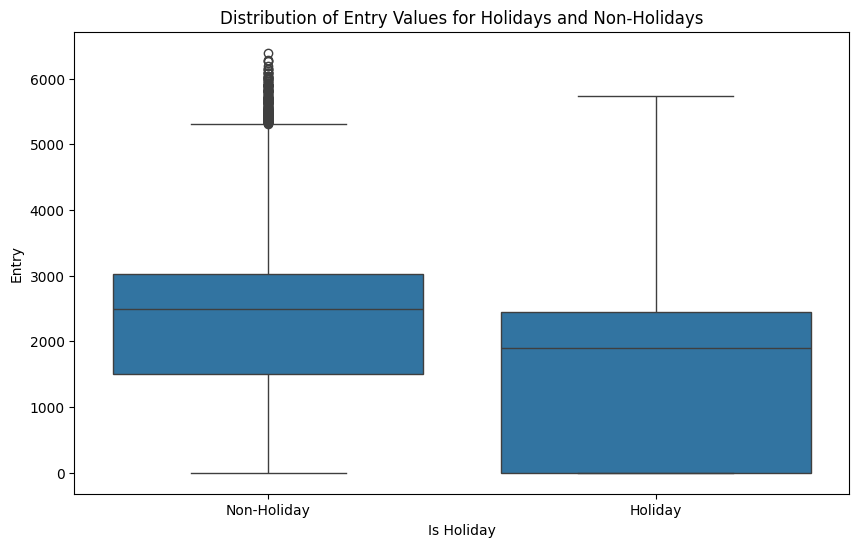

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot to visualize the distribution of Entry values for holidays and non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Entry', data=df)
plt.title('Distribution of Entry Values for Holidays and Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Entry')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [238]:
from scipy.stats import ttest_ind

# Perform t-test
holiday_entries = df[df['is_holiday'] == 1]['Entry']
non_holiday_entries = df[df['is_holiday'] == 0]['Entry']

t_stat, p_value = ttest_ind(holiday_entries, non_holiday_entries, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between holidays and non-holidays.")

T-statistic: -16.172073238245833, P-value: 3.2099421304437347e-52
Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.


In [239]:
# Calculate mean and standard deviation for each rain_class
rain_class_stats = df.groupby('rain_class')['Entry'].agg(['mean', 'std']).reset_index()
print(rain_class_stats)

   rain_class         mean          std
0           0  2145.033235  1300.077212
1           1  2189.014583  1294.567424
2           2  2384.725820  1307.742238
3           3  2244.148837  1302.094956
4           4  2103.780864  1270.273438
5           5  1112.050000   613.758265


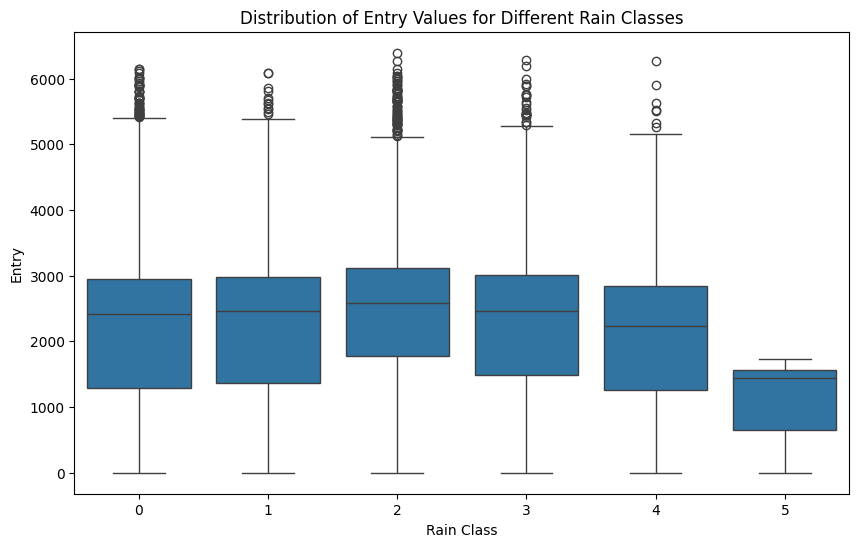

F-statistic: 20.975342571662864, P-value: 5.907390644949e-21
Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.


In [240]:
# Box plot to visualize the distribution of Entry values for different rain classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_class', y='Entry', data=df)
plt.title('Distribution of Entry Values for Different Rain Classes')
plt.xlabel('Rain Class')
plt.ylabel('Entry')
plt.show()

from scipy.stats import f_oneway

# Perform ANOVA
rain_class_groups = [df[df['rain_class'] == rc]['Entry'] for rc in df['rain_class'].unique()]
f_stat, p_value = f_oneway(*rain_class_groups)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between different rain classes.")

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     0      1    43.9813 0.8164    -56.992  144.9547  False
     0      2   239.6926    0.0    164.987  314.3982   True
     0      3    99.1156 0.0538    -0.9123  199.1435  False
     0      4   -41.2524 0.9808  -206.9189  124.4142  False
     0      5 -1032.9832 0.0052 -1862.6727 -203.2938   True
     1      2   195.7112    0.0    87.4189  304.0035   True
     1      3    55.1343  0.819   -71.9558  182.2243  False
     1      4   -85.2337  0.771  -268.5141   98.0466  False
     1      5 -1076.9646 0.0032 -1910.3498 -243.5794   True
     2      3   -140.577 0.0026  -247.9883  -33.1656   True
     2      4   -280.945    0.0  -451.1713 -110.7186   True
     2      5 -1272.6758 0.0002 -2103.2878 -442.0639   True
     3      4   -140.368 0.2428  -323.1292   42.3933  False
     3      5 -1132.0988 0.0015   -1965.

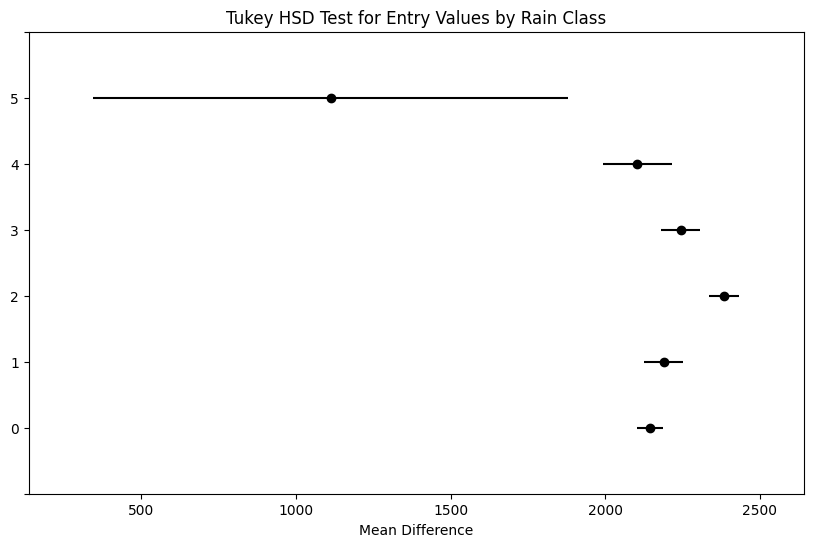

In [241]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Entry'], groups=df['rain_class'], alpha=0.05)
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test for Entry Values by Rain Class')
plt.xlabel('Mean Difference')
plt.show()

c:\Users\inspiron-7460\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: keras_tensor_66. Received: the structure of inputs=['*']



Original SHAP values shape: (1458, 20, 8, 1)
Reshaped SHAP values shape: (1458, 20, 8)
Averaged SHAP values shape: (1458, 8)
X_test_flat shape: (1458, 7)


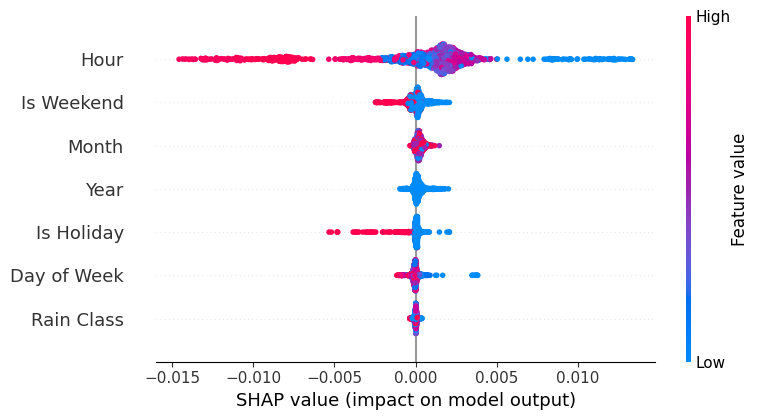

In [242]:
import numpy as np
import shap

# Create a background dataset for SHAP using a larger sample from the training set
background = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the entire test dataset
shap_values = explainer.shap_values(X_test)  # Use the entire test dataset

# Check the shape of shap_values
print("Original SHAP values shape:", shap_values.shape)

# Reshape the SHAP values to (n_samples, n_timesteps, n_features)
shap_values_flat = shap_values.reshape(X_test.shape[0], 20, -1)
print("Reshaped SHAP values shape:", shap_values_flat.shape)

# Average across the time steps
shap_values_avg = np.mean(shap_values_flat, axis=1)  # Now the shape will be (n_samples, n_features)
print("Averaged SHAP values shape:", shap_values_avg.shape)

# Prepare X_test for plotting (only keep the features excluding 'Entry')
X_test_flat = X_test[:, -1, :-1]  # Take the last time step and exclude 'Entry'
print("X_test_flat shape:", X_test_flat.shape)

# Ensure the number of features matches (we will take only the first 7 features for SHAP)
shap_values_avg = shap_values_avg[:, :-1]  # Exclude the last feature to match

# Now the shapes should match
assert shap_values_avg.shape[1] == X_test_flat.shape[1], \
    f"SHAP values shape: {shap_values_avg.shape[1]}, X_test_flat shape: {X_test_flat.shape[1]}"

# Define feature names according to your dataset (excluding 'Entry')
feature_names = ['Hour', 'Day of Week', 'Is Weekend', 'Is Holiday', 'Month', 'Year', 'Rain Class']

# Plot the SHAP summary with feature names
shap.summary_plot(shap_values_avg, X_test_flat, feature_names=feature_names)

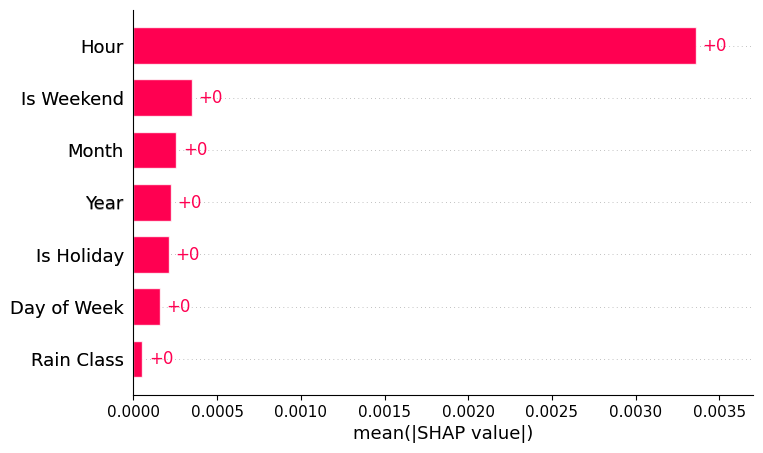

In [243]:
# Create an Explanation object
shap_explanation = shap.Explanation(values=shap_values_avg, feature_names=feature_names, data=X_test_flat)

# Plot the SHAP values
shap.plots.bar(shap_explanation)


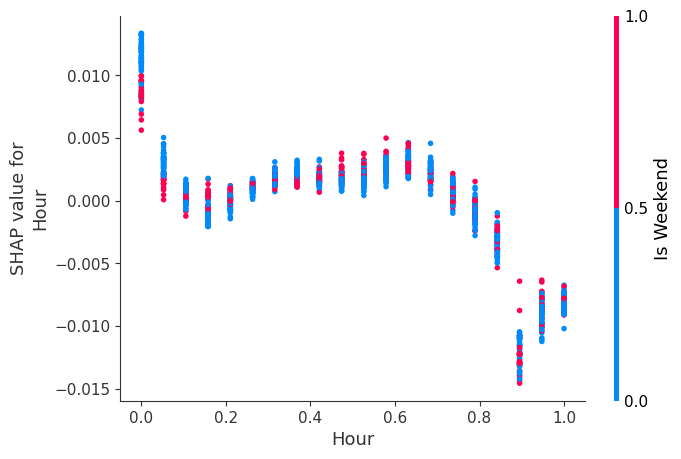

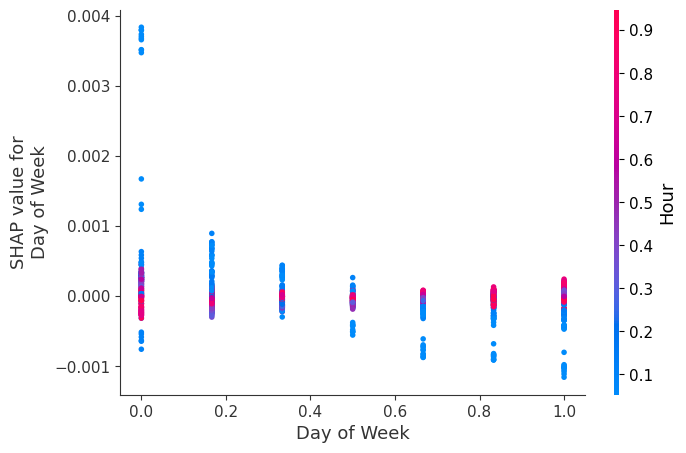

In [244]:
# 2. Plot SHAP Dependence Plot for the first feature (Hour)
shap.dependence_plot(0, shap_values_avg, X_test_flat, feature_names=feature_names)
shap.dependence_plot(1, shap_values_avg, X_test_flat, feature_names=feature_names)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


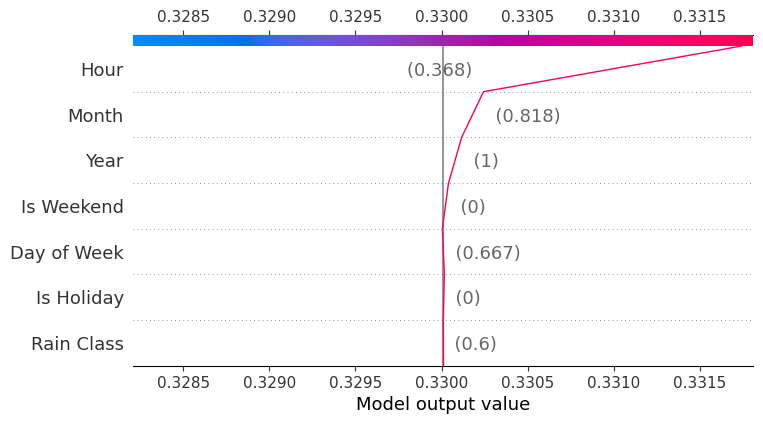

In [245]:
# Calculate the expected value for the model
expected_value = np.mean(model.predict(background))

# 3. Plot SHAP Decision Plot for the first prediction (the last time step)
shap.decision_plot(expected_value, shap_values_avg[6], X_test_flat[6], feature_names=feature_names)


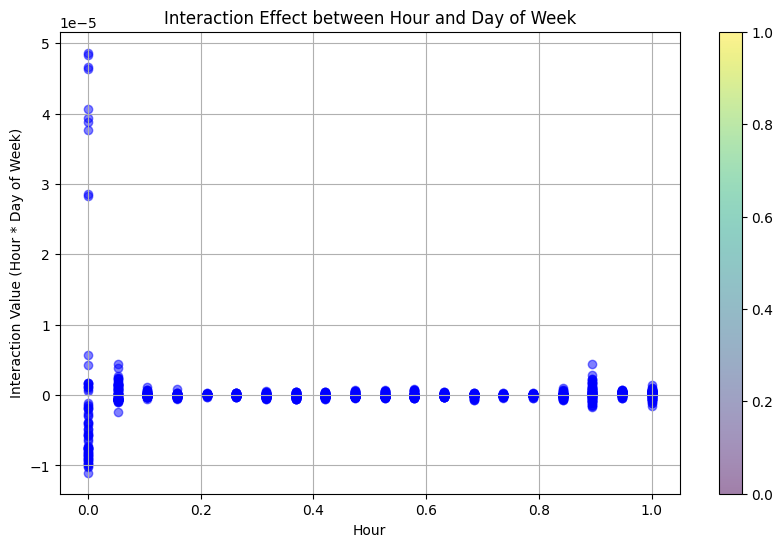

In [246]:
# 5. Manually calculate and plot interaction effects for the first two features (Hour and Day of Week)
# Note: This is a manual workaround, assuming interaction effects are calculated based on shap values
interaction_values = shap_values_avg[:, 0] * shap_values_avg[:, 1]  # Replace 0 and 1 with the indices of features you want to analyze
plt.figure(figsize=(10, 6))
plt.scatter(X_test_flat[:, 0], interaction_values, c='blue', alpha=0.5)
plt.colorbar()
plt.xlabel('Hour')
plt.ylabel('Interaction Value (Hour * Day of Week)')
plt.title('Interaction Effect between Hour and Day of Week')
plt.grid()
plt.show()

In [247]:
'''# Create a background dataset for SHAP using a larger sample from the training set
background = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Select a specific instance from X_test
instance_index = 0  # Change this index to select different instances
instance = X_test[instance_index:instance_index + 1]

# Compute SHAP values for the specific instance
shap_values_instance = explainer.shap_values(instance)

# Reshape the SHAP values to (n_timesteps, n_features) for the selected instance
shap_values_instance_flat = shap_values_instance.reshape(1, 8)  # Assuming 19 timesteps and 8 features

# Average SHAP values across time steps (or you can pick one specific time step)
shap_values_instance_avg = np.mean(shap_values_instance_flat, axis=0)  # Averaging over time steps
print("Averaged SHAP values shape for the instance:", shap_values_instance_avg.shape)

# Prepare the corresponding feature values (excluding the 'Entry' target variable)
instance_features = instance[:, -1, :-1]  # Take the last time step and exclude 'Entry'
print("Instance feature values shape:", instance_features.shape)

# Define feature names according to your dataset (excluding 'Entry')
feature_names = ['Hour', 'Day of Week', 'Is Weekend', 'Is Holiday', 'Month', 'Year', 'Rain Class']

# Compute the model output for the selected instance
model_output = model(instance)  # Get the model's predicted output for the instance

# Plot the SHAP waterfall plot for the specific instance
shap.waterfall_plot(
    shap.Explanation(values=shap_values_instance_avg[:-1],  # Exclude the 'Entry' SHAP value
                     base_values=model_output.numpy()[0],  # Use the model's output as the base value
                     data=instance_features[0],  # Feature values for this instance
                     feature_names=feature_names)
)'''



'# Create a background dataset for SHAP using a larger sample from the training set\nbackground = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]\n\n# Initialize SHAP GradientExplainer\nexplainer = shap.GradientExplainer(model, background)\n\n# Select a specific instance from X_test\ninstance_index = 0  # Change this index to select different instances\ninstance = X_test[instance_index:instance_index + 1]\n\n# Compute SHAP values for the specific instance\nshap_values_instance = explainer.shap_values(instance)\n\n# Reshape the SHAP values to (n_timesteps, n_features) for the selected instance\nshap_values_instance_flat = shap_values_instance.reshape(1, 8)  # Assuming 19 timesteps and 8 features\n\n# Average SHAP values across time steps (or you can pick one specific time step)\nshap_values_instance_avg = np.mean(shap_values_instance_flat, axis=0)  # Averaging over time steps\nprint("Averaged SHAP values shape for the instance:", shap_values_insta

In [291]:
# Load the scalers
scaler = joblib.load('model/scaler_features.pkl')
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Select a random starting index
random_start_index = np.random.randint(0, len(df_model) - 19)

# Select the next 19 rows starting from the random index
random_rows = df_model.iloc[random_start_index:random_start_index + 19]

# Inverse scale the selected rows
random_rows_inverse_scaled = random_rows.copy()
random_rows_inverse_scaled[random_rows.columns[:-1]] = scaler.inverse_transform(random_rows[random_rows.columns[:-1]])
random_rows_inverse_scaled['Entry'] = scaler_entry.inverse_transform(random_rows[['Entry']])


In [292]:
# Manually input the 20th row
manual_row = pd.DataFrame({
    'hour': [4],
    'day_of_week': [5],
    'is_weekend': [0],
    'is_holiday': [0],
    'month': [1],
    'year': [2030],
    'rain_class': [5],
    'Entry': [0]  # Placeholder for the entry value
})

In [293]:
# Combine the random rows and the manual row
input_df = pd.concat([random_rows_inverse_scaled, manual_row], ignore_index=True)

# Scale the input DataFrame
input_df_scaled = input_df.copy()
input_df_scaled[input_df.columns[:-1]] = scaler.transform(input_df[input_df.columns[:-1]])
input_df_scaled['Entry'] = scaler_entry.transform(input_df[['Entry']])  # Scale 'Entry'

# Prepare the input for the model
input_data = input_df_scaled.values.reshape((1, 20, -1))  # Adjust the shape to match the model's expected input

# Make predictions using the model
predictions = model.predict(input_data)

# Write the prediction to the 19th index of the DataFrame
input_df.at[19, 'Entry'] = scaler_entry.inverse_transform(predictions)[0, 0]
input_df.head(20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


,hour,day_of_week,is_weekend,is_holiday,month,year,rain_class,Entry
0,5.0,6.0,1.0,0.0,5.0,2022.0,0.0,2271.00000
1,6.0,6.0,1.0,0.0,5.0,2022.0,0.0,3929.50000
2,7.0,6.0,1.0,0.0,5.0,2022.0,0.0,5074.50000
3,8.0,6.0,1.0,0.0,5.0,2022.0,0.0,4584.50000
4,9.0,6.0,1.0,0.0,5.0,2022.0,0.0,3658.00000
5,10.0,6.0,1.0,0.0,5.0,2022.0,0.0,2919.50000
6,11.0,6.0,1.0,0.0,5.0,2022.0,0.0,2874.00000
7,12.0,6.0,1.0,0.0,5.0,2022.0,0.0,2831.50000
8,13.0,6.0,1.0,0.0,5.0,2022.0,0.0,2687.00000
9,14.0,6.0,1.0,0.0,5.0,2022.0,0.0,2698.00000


In [294]:
print("Scaled input_df before prediction:")
print(input_df_scaled)


Scaled input_df before prediction:
        hour  day_of_week  is_weekend  is_holiday     month  year  rain_class  \
0   0.052632     1.000000         1.0         0.0  0.363636   0.0         0.0   
1   0.105263     1.000000         1.0         0.0  0.363636   0.0         0.0   
2   0.157895     1.000000         1.0         0.0  0.363636   0.0         0.0   
3   0.210526     1.000000         1.0         0.0  0.363636   0.0         0.0   
4   0.263158     1.000000         1.0         0.0  0.363636   0.0         0.0   
5   0.315789     1.000000         1.0         0.0  0.363636   0.0         0.0   
6   0.368421     1.000000         1.0         0.0  0.363636   0.0         0.0   
7   0.421053     1.000000         1.0         0.0  0.363636   0.0         0.0   
8   0.473684     1.000000         1.0         0.0  0.363636   0.0         0.0   
9   0.526316     1.000000         1.0         0.0  0.363636   0.0         0.0   
10  0.578947     1.000000         1.0         0.0  0.363636   0.0         

In [295]:
print("Predicted value (before inverse scaling):", predictions)
print("Predicted value (after inverse scaling):", scaler_entry.inverse_transform(predictions))


Predicted value (before inverse scaling): [[0.6026189]]
Predicted value (after inverse scaling): [[3852.5425]]


In [296]:
# Check if the scaled values are within a reasonable range
print("Scaled manual row before prediction:")
print(input_df_scaled.iloc[-1])  # Print the last row (manual input row)

# Check if the model outputs a reasonable scaled prediction
prediction_scaled = model.predict(input_data)
print("Scaled prediction:", prediction_scaled)

# Inverse scale the prediction
prediction_inverse = scaler_entry.inverse_transform(prediction_scaled)
print("Inverse-scaled prediction:", prediction_inverse)


Scaled manual row before prediction:
hour           0.000000
day_of_week    0.833333
is_weekend     0.000000
is_holiday     0.000000
month          0.000000
year           8.000000
rain_class     1.000000
Entry          0.000000
Name: 19, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Scaled prediction: [[0.6026189]]
Inverse-scaled prediction: [[3852.5425]]
